### First experiments with U-Net on real world slp data

Try U-Net following [Xiantao et al., 2020](https://www.nature.com/articles/s41598-020-59801-x), but with only 4 convolutions, opposed to 5.
Work with real world slp samples. Omit final row, to have number of rows evenly divideable by 2 for all three max pooling operations.

Choose **mask type**: Can either have random sparsity mask, individually for each data sample ('variable'), or create only a single random mask, that is then applied to all samples identically ('fixed'). 
And optionally extend data with **augmentation factor**: Specify the number of times, each sample is to be cloned, keeping the original order.

#### Experiments:

1) **mask_type='fixed', augmentation_factor=1:** Base experiment, according to szenario to have limitet number of measurements from stations, that are fixed in their location. Fast to train, low ressources required.
2) **mask_type='variable', augmentation_factor=1:** Extends base experiment, can handle variable inputs with fixed sparsity in single model. Fits to observations from e.g. argo floats on their trajectory or well suited for e.g. sea surface temperature measurements, where varying cloud coverage limits infrared observations. In its simples form, use each sample only once. Expect worse performance, commpared to base experiment.
3) **mask_type='variable', augmentation_factor>0:** Improve performance by using each input sample multiple times, allowed by random sparsity. Try to reduce overfitting and increase generalization on unseen data. Comes at the expense of increased training time.
4) Drive sparsity to its extreme: Add inputs in **decreasing order of variance**. Might need to skip several grid points in the exact order, since we want to capture variance from different spots of high variance.

Use **sparse and scaled (to [0,1]) samples as inputs**. Use **complete and scaled (to [0,1]) samples as targets**.

Got results on nesh, using GPU cluster node with batch **unet_4conv_slp_realworld.py**. Specify **mask_type** and **augmentation_factor**!

In [1]:
import os
import sys
sys.path.append('../src')
from pathlib import Path
from json import dump, load

import numpy as np
from matplotlib import pyplot as plt

from data import load_data, clone_data, create_sparsity_mask, split_and_scale_data
from models import build_unet_4conv

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Set working directory, according to working directory in scripts:
os.chdir('/gxfs_work1/geomar/smomw511')

In [3]:
# Specify experiment:
model_config = 'unet_4conv'
source = 'slp_realworld'
mask_type = 'fixed'
augmentation_factor = 1

# Reconstruct path to experiment:
path = Path('GitHub/MarcoLandtHayen/reconstruct-sparse-inputs/results/'+model_config+"_"+source+'_'+mask_type+'_factor_'+str(augmentation_factor))

# Reload parameters for this experiment:
with open(path / 'parameters.json', 'r') as f:
    parameters=load(f)

train_val_split = parameters['train_val_split']
sparsity_all = parameters['sparsity_all']
scale_to = parameters['scale_to']
epochs = parameters['epochs']

Sparsity:  0.99
[0.20974333 0.00771579 0.00354538 0.00200404 0.00165731 0.00140805
 0.00135908 0.00125294 0.00119057 0.00112825 0.00110469]
[0.20378388 0.00748417 0.00380702 0.00220547 0.00188422 0.00160173
 0.00153605 0.00144642 0.0013599  0.00125182 0.00122182] 



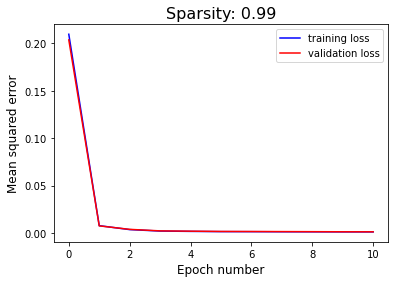

Sparsity:  0.95
[0.20899039 0.00658097 0.00250994 0.00162519 0.00132283 0.00156054
 0.00092983 0.00071512 0.00064836 0.0005928  0.00047191]
[0.2030557  0.00673099 0.00262689 0.0018056  0.001497   0.00162761
 0.00101749 0.00082024 0.00075615 0.00070506 0.00057046] 



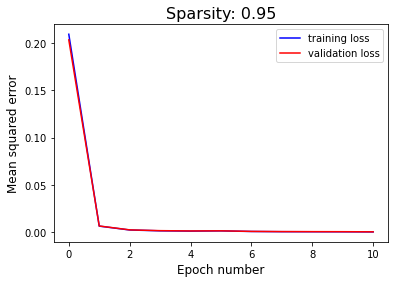

Sparsity:  0.9
[0.20839033 0.00586547 0.00180739 0.00126399 0.00101653 0.00069669
 0.00052871 0.00041114 0.00034816 0.00032115 0.00025347]
[0.2024794  0.00594543 0.00199175 0.00147108 0.00113764 0.00078142
 0.00061856 0.0004838  0.00042679 0.00038334 0.00030278] 



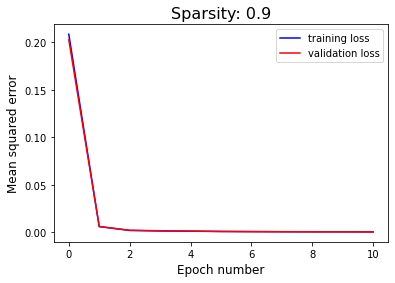

Sparsity:  0.75
[2.09230175e-01 2.20213961e-03 9.84534571e-04 5.80637992e-04
 3.92815403e-04 3.01610754e-04 2.49824888e-04 1.94611767e-04
 1.76489731e-04 1.56742701e-04 1.47003604e-04]
[2.03287414e-01 2.23290739e-03 1.06775086e-03 6.39285711e-04
 4.44563977e-04 3.52248789e-04 2.95043633e-04 2.36434541e-04
 2.14121910e-04 1.91530277e-04 1.81962651e-04] 



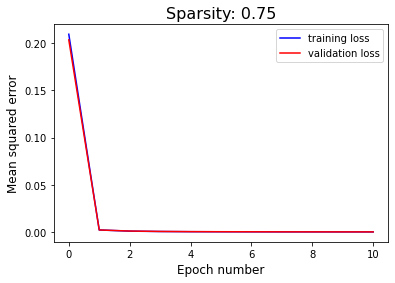

Sparsity:  0.5
[2.08028246e-01 9.94896585e-04 4.32095189e-04 3.48932250e-04
 2.72095386e-04 2.40503793e-04 2.18879002e-04 1.89994995e-04
 1.88421466e-04 1.56196113e-04 1.38278827e-04]
[2.02142439e-01 1.03698061e-03 4.49117237e-04 3.64136039e-04
 2.93580345e-04 2.62901494e-04 2.44161491e-04 2.13453913e-04
 2.14792953e-04 1.82861207e-04 1.64442510e-04] 



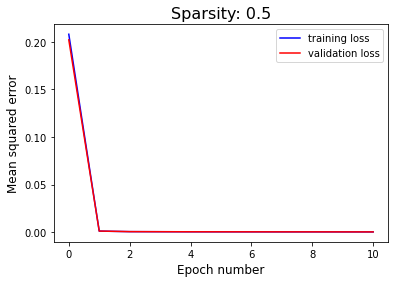

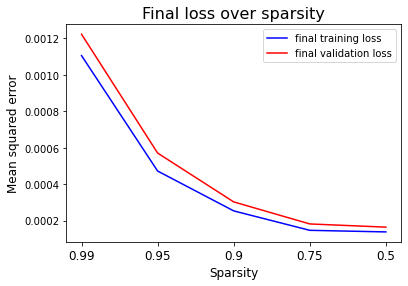

In [10]:
## Get an overview of train and validation loss, depending on sparsity.
## Note: Start with epoch 0, hence untrained model.

# Initialize storage for final train and validation loss:
train_loss_final = []
val_loss_final = []

# Loop over array of desired sparsity:
for i in range(len(sparsity_all)):
        
    # Get current sparsity:
    sparsity = sparsity_all[i]
    
    # Reload loss:
    train_loss = np.load(path / 'sparsity_' f'{int(sparsity*100)}'/ 'train_loss.npy')
    val_loss = np.load(path / 'sparsity_' f'{int(sparsity*100)}'/ 'val_loss.npy')
    
    print("Sparsity: ", sparsity)
    print(train_loss)
    print(val_loss,"\n")
    
    # Plot train and val_loss (bin. cross-entropy)
    plt.plot(train_loss, color = 'blue', label = 'training loss')
    plt.plot(val_loss, color = 'red', label = 'validation loss')
    plt.xlabel('Epoch number', fontsize=12)
    plt.ylabel('Mean squared error', fontsize=12)
    #plt.ylim(0.6, 0.8)
    plt.title('Sparsity: '+str(sparsity), fontsize=16)
    plt.legend()
    plt.show() 
    
    # Store final train and validation loss:
    train_loss_final.append(train_loss[-1])
    val_loss_final.append(val_loss[-1])

# Plot final train and validation loss over sparsity:
plt.plot(train_loss_final, color = 'blue', label = 'final training loss')
plt.plot(val_loss_final, color = 'red', label = 'final validation loss')
plt.xlabel('Sparsity', fontsize=12)
plt.ylabel('Mean squared error', fontsize=12)
plt.xticks(np.arange(0, len(sparsity_all), step=1), sparsity_all, fontsize=12)
#plt.ylim(0.6, 0.8)
plt.title('Final loss over sparsity', fontsize=16)
plt.legend()
plt.show() 

### Inspect all models

In [5]:
# Load data, only to infer sample dimensions (lat,lon):
data = load_data(source=source)

In [11]:
## Compare predictions and targets, depending on sparsity and training progress (epoch).
## Note: Start with epoch 0, hence untrained model.

# Specify number of samples to be considered (to minimize computational effort):
n_samples = 2

# Initialize storage for train and validation inputs: Dimensions (#sparsities, #samples, lat, lon)
train_input_all = np.zeros((len(sparsity_all), n_samples, data.shape[1], data.shape[2]))
val_input_all = np.zeros((len(sparsity_all), n_samples, data.shape[1], data.shape[2]))

# Initialize storage for train and validation targets: Dimensions (#samples, lat, lon)
train_target_all = np.zeros((n_samples, data.shape[1], data.shape[2]))
val_target_all = np.zeros((n_samples, data.shape[1], data.shape[2]))

# Initialize storage for train and validation predictions: Dimensions (#sparsities, #epochs + 1, #samples, lat, lon)
train_pred_all = np.zeros((len(sparsity_all), epochs+1, n_samples, data.shape[1], data.shape[2]))
val_pred_all = np.zeros((len(sparsity_all), epochs+1, n_samples, data.shape[1], data.shape[2]))

# Loop over array of desired sparsity:
for i in range(len(sparsity_all)):
        
    # Get current sparsity:
    sparsity = sparsity_all[i]
    
    # Show status:
    print('Sparsity: ', i+1, ' of ', len(sparsity_all))
    
    ## Load complete data, reconstruct sparse data and inputs and targets:

    # Load data:
    data = load_data(source=source)
    
    # Extend data:
    data = clone_data(data=data, augmentation_factor=augmentation_factor)

    # Reload sparsity mask:
    sparsity_mask = np.load(path / 'sparsity_' f'{int(sparsity*100)}' / 'sparsity_mask.npy')
    
    # Use sparse data as inputs and complete data as targets. Split sparse and complete data into training and validation sets. 
    # Scale or normlalize data according to statistics obtained from only training data.
    train_input, val_input, train_target, val_target, train_min, train_max, train_mean, train_std = split_and_scale_data(
        data, 
        sparsity_mask, 
        train_val_split, 
        scale_to
    )
    
    # Store inputs: Omit final dimension of predictions, that only contains the channel (here: 1)
    train_input_all[i,:,:,:] = train_input[:n_samples,:,:,0]
    val_input_all[i,:,:,:] = val_input[:n_samples,:,:,0]
    
    # Store targets: Only once!
    train_target_all[:,:,:] = train_target[:n_samples,:,:]
    val_target_all[:,:,:] = val_target[:n_samples,:,:]
    
    # Loop over number of epochs:
    for j in range(epochs+1):
        
        # Show status:
        print('  Epoch: ', j, ' of ', epochs)
        
        # Reload desired model:
        model = tf.keras.models.load_model(path / 'sparsity_' f'{int(sparsity*100)}' / f'epoch_{j}')
        
        # Get model predictions on train and validation data (only first 2 samples):
        train_pred = model.predict(train_input[:n_samples])
        val_pred = model.predict(val_input[:n_samples])
        
        # Store predictions: Omit final dimension of predictions, that only contains the channel (here: 1)
        train_pred_all[i,j,:,:,:] = train_pred[:,:,:,0]
        val_pred_all[i,j,:,:,:] = val_pred[:,:,:,0]

Sparsity:  1  of  5
  Epoch:  0  of  10
  Epoch:  1  of  10
  Epoch:  2  of  10
  Epoch:  3  of  10
  Epoch:  4  of  10
  Epoch:  5  of  10
  Epoch:  6  of  10
  Epoch:  7  of  10
  Epoch:  8  of  10
  Epoch:  9  of  10
  Epoch:  10  of  10
Sparsity:  2  of  5
  Epoch:  0  of  10
  Epoch:  1  of  10
  Epoch:  2  of  10
  Epoch:  3  of  10
  Epoch:  4  of  10
  Epoch:  5  of  10
  Epoch:  6  of  10
  Epoch:  7  of  10
  Epoch:  8  of  10
  Epoch:  9  of  10
  Epoch:  10  of  10
Sparsity:  3  of  5
  Epoch:  0  of  10
  Epoch:  1  of  10
  Epoch:  2  of  10
  Epoch:  3  of  10
  Epoch:  4  of  10
  Epoch:  5  of  10
  Epoch:  6  of  10
  Epoch:  7  of  10
  Epoch:  8  of  10
  Epoch:  9  of  10
  Epoch:  10  of  10
Sparsity:  4  of  5
  Epoch:  0  of  10
  Epoch:  1  of  10
  Epoch:  2  of  10
  Epoch:  3  of  10
  Epoch:  4  of  10
  Epoch:  5  of  10
  Epoch:  6  of  10
  Epoch:  7  of  10
  Epoch:  8  of  10
  Epoch:  9  of  10
  Epoch:  10  of  10
Sparsity:  5  of  5
  Epoch:  0  of 

In [12]:
## Plot for single TRAINING input sample: Sparse input, target (=complete data) and predictions over the epochs (start with 0, hence untrained model),
## for specific sparsity:

# Select sparsity setting:
i=1

# Pick sample:
k=0

# Check:
print("Sparsity: ", sparsity_all[i])

Sparsity:  0.95


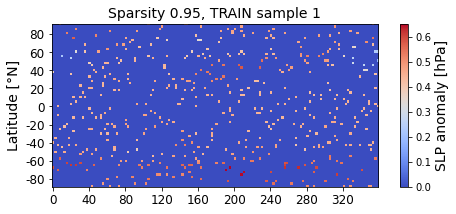

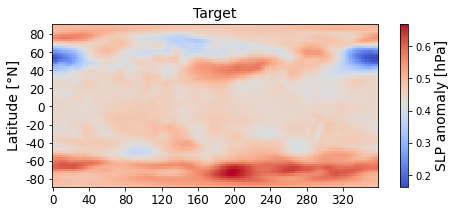

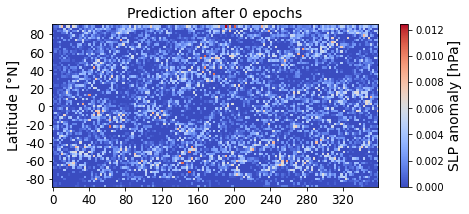

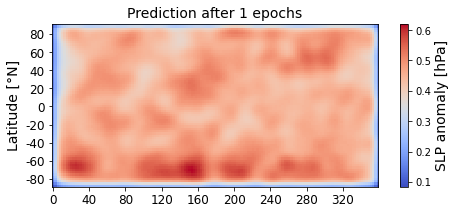

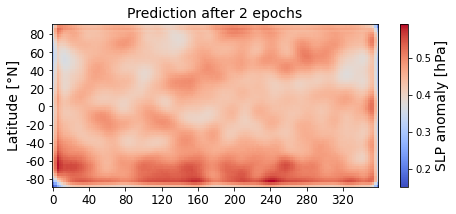

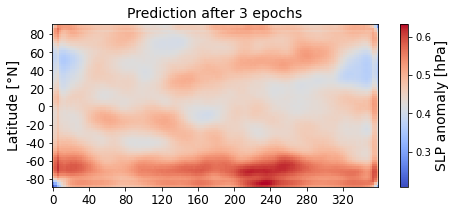

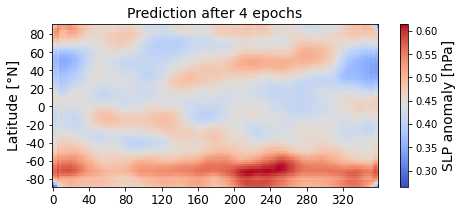

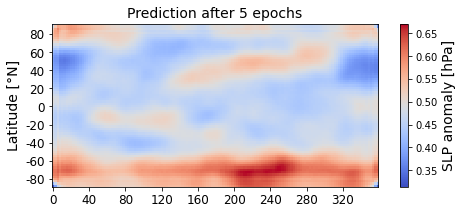

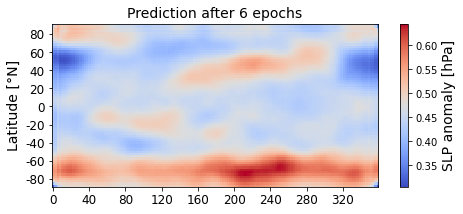

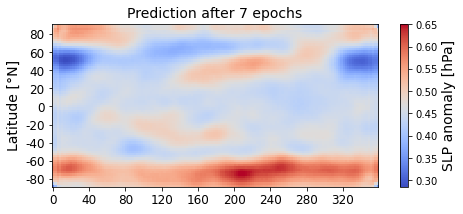

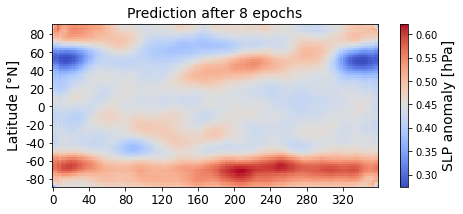

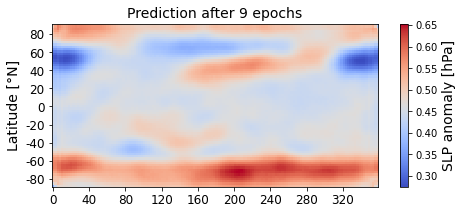

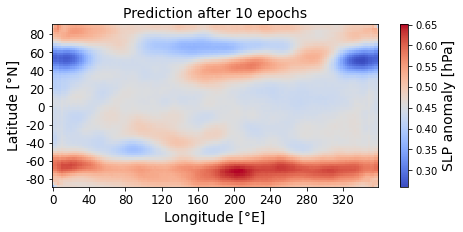

In [13]:
## Plot desired input sample from TRAINING data:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(train_input_all[i,k,:,:], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Sparsity '+str(sparsity_all[i])+', TRAIN sample '+str(k+1), fontsize=14)
#plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot corresponding target:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(train_target_all[k], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Target', fontsize=14)
#plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot corresponding model prediction:

# Loop over epochs:
for j in range(epochs+1):

    fig, ax = plt.subplots(figsize=(8, 3))

    im = plt.imshow(train_pred_all[i,j,k,:,:], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label("SLP anomaly [hPa]", fontsize=14)

    plt.title('Prediction after '+str(j)+' epochs', fontsize=14)
    if j == epochs:
        plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

    plt.show()


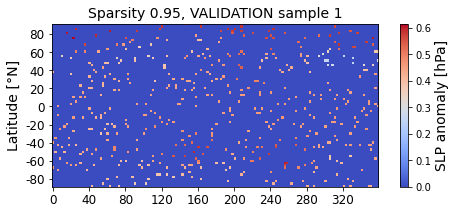

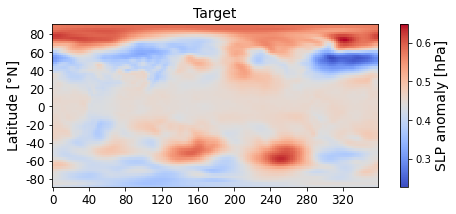

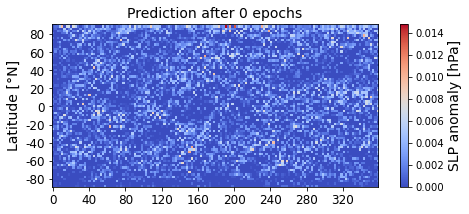

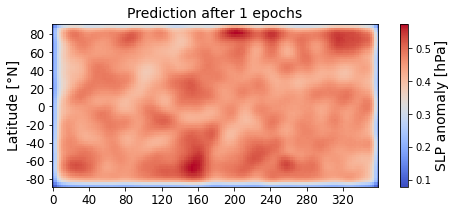

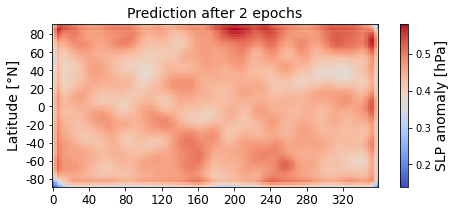

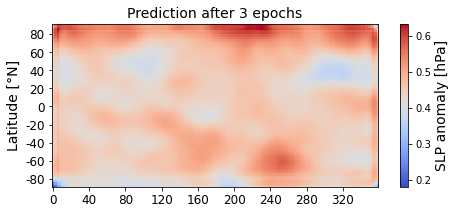

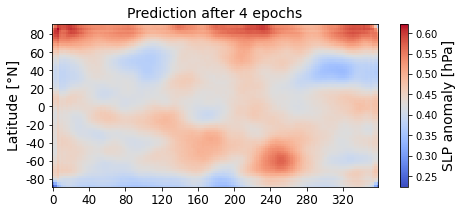

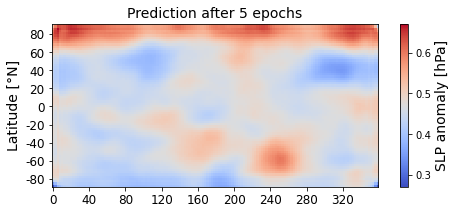

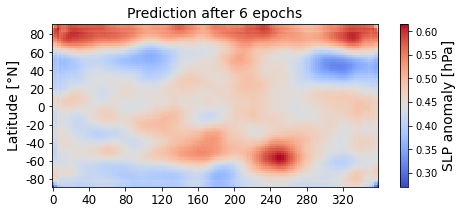

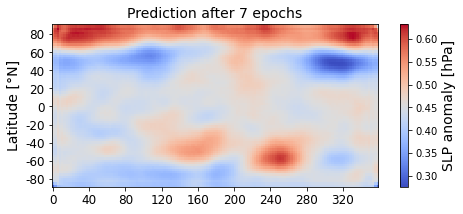

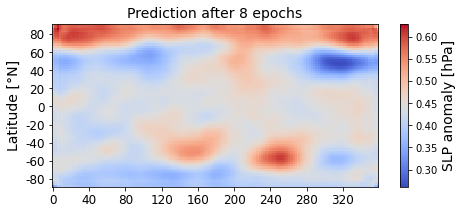

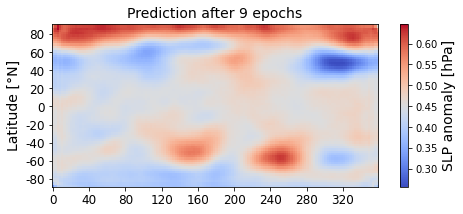

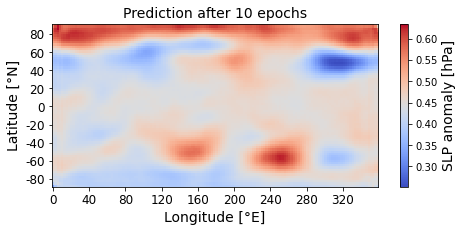

In [14]:
## Plot desired input sample from VALIDATION data:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(val_input_all[i,k,:,:], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Sparsity '+str(sparsity_all[i])+', VALIDATION sample '+str(k+1), fontsize=14)
#plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot corresponding target:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(val_target_all[k], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Target', fontsize=14)
#plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot corresponding model prediction:

# Loop over epochs:
for j in range(epochs+1):

    fig, ax = plt.subplots(figsize=(8, 3))

    im = plt.imshow(val_pred_all[i,j,k,:,:], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label("SLP anomaly [hPa]", fontsize=14)

    plt.title('Prediction after '+str(j)+' epochs', fontsize=14)
    if j == epochs:
        plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

    plt.show()

In [15]:
## Plot for single TRAINING input sample: Target (=complete data) and predictions after specified epoch for ALL sparsities:

# Specify epoch:
j=10

# Pick sample:
k=0

# Check:
print("Prediction after epoch: ", j)

Prediction after epoch:  10


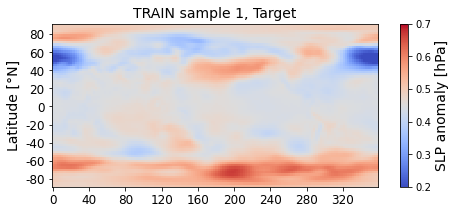

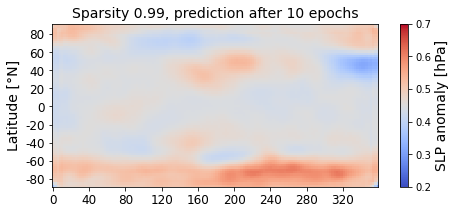

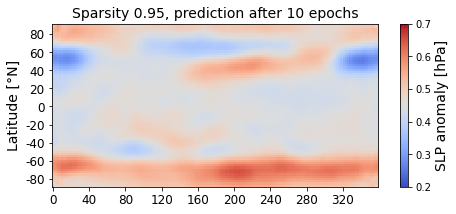

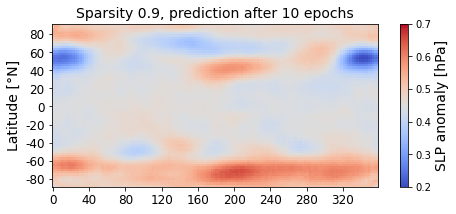

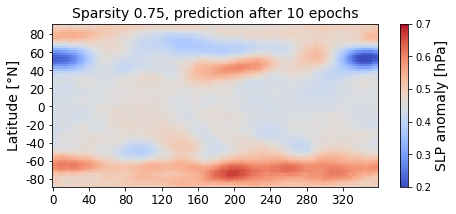

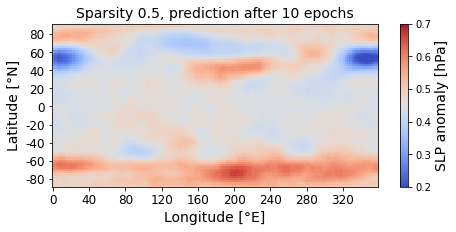

In [16]:
## Plot target from TRAINING data:

fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(train_target_all[k], cmap="coolwarm", interpolation='nearest', vmin=0.2, vmax=0.7)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('TRAIN sample '+str(k+1)+', Target', fontsize=14)
#plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot corresponding model prediction:

# Loop over sparsity settings:
for i in range(len(sparsity_all)):

    fig, ax = plt.subplots(figsize=(8, 3))

    im = plt.imshow(train_pred_all[i,j,k,:,:], cmap="coolwarm", interpolation='nearest', vmin=0.2, vmax=0.7)
    cbar = plt.colorbar(im)
    cbar.set_label("SLP anomaly [hPa]", fontsize=14)

    plt.title('Sparsity '+str(sparsity_all[i])+', prediction after '+str(j)+' epochs', fontsize=14)
    if i == len(sparsity_all)-1:
        plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

    plt.show()

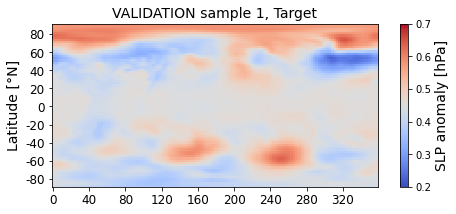

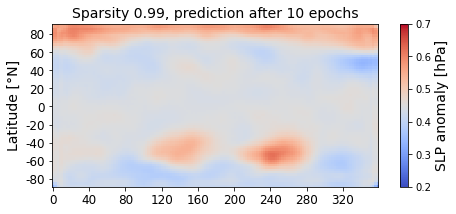

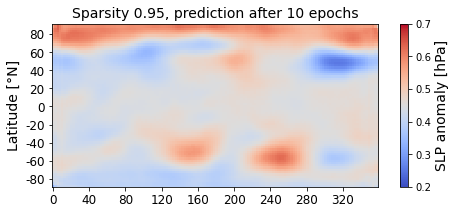

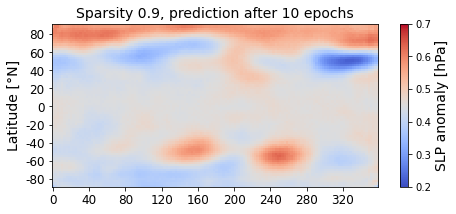

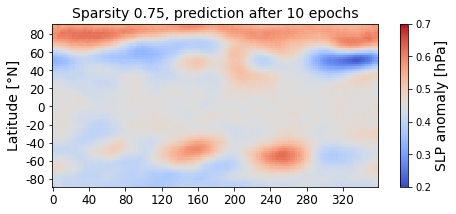

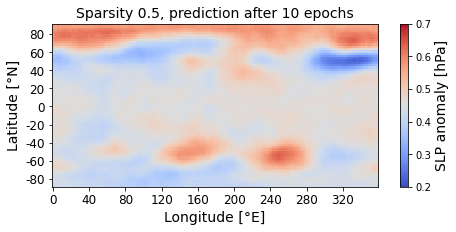

In [17]:
## Plot target from VALIDATION data:

fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(val_target_all[k], cmap="coolwarm", interpolation='nearest', vmin=0.2, vmax=0.7)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('VALIDATION sample '+str(k+1)+', Target', fontsize=14)
#plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot corresponding model prediction:

# Loop over sparsity settings:
for i in range(len(sparsity_all)):

    fig, ax = plt.subplots(figsize=(8, 3))

    im = plt.imshow(val_pred_all[i,j,k,:,:], cmap="coolwarm", interpolation='nearest', vmin=0.2, vmax=0.7)
    cbar = plt.colorbar(im)
    cbar.set_label("SLP anomaly [hPa]", fontsize=14)

    plt.title('Sparsity '+str(sparsity_all[i])+', prediction after '+str(j)+' epochs', fontsize=14)
    if i == len(sparsity_all)-1:
        plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

    plt.show()

### Inspect single model

In [17]:
# Set parameters to reload specific model:
sparsity = 0.75
epoch = 3

In [18]:
## Load complete data, reconstruct sparse data and inputs and targets:

# Load data:
data = load_data(source=source)

# Extend data:
data = clone_data(data=data, augmentation_factor=augmentation_factor)

# Reload sparsity mask:
sparsity_mask = np.load(path / 'sparsity_' f'{int(sparsity*100)}' / 'sparsity_mask.npy')

In [19]:
# Use sparse data as inputs and complete data as targets. Split sparse and complete data into training and validation sets. 
# Scale or normlalize data according to statistics obtained from only training data.
train_input, val_input, train_target, val_target, train_min, train_max, train_mean, train_std = split_and_scale_data(
    data, 
    sparsity_mask, 
    train_val_split, 
    scale_to
)

In [92]:
# Reload desired model:
model = tf.keras.models.load_model(path / 'sparsity_' f'{int(sparsity*100)}' / f'epoch_{epoch}')

In [93]:
# Get model predictions on train and validation data (only first 10 samples):
train_pred = model.predict(train_input[:10])
val_pred = model.predict(val_input[:10])

In [94]:
# Pick input to visualize sparse input, target (=complete data) and model prediction:
i = 0

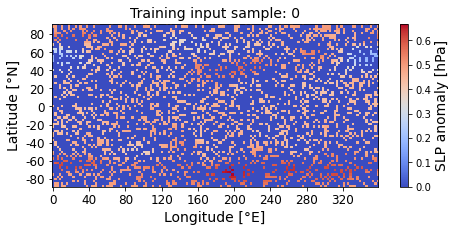

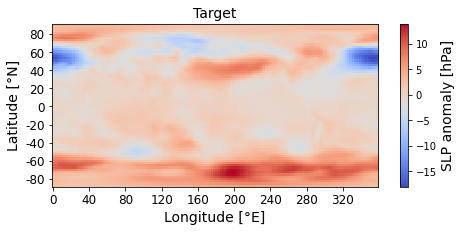

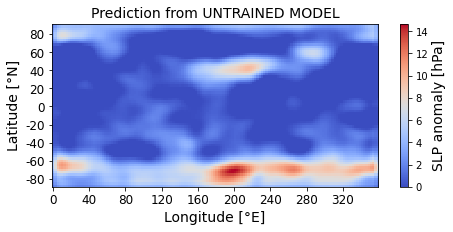

In [95]:
## Plot first input sample from TRAINING data:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(train_input[i], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Training input sample: '+str(i), fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot corresponding target:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(train_target[i], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Target', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot corresponding model prediction:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(train_pred[i,:,:,0], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Prediction from UNTRAINED MODEL', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

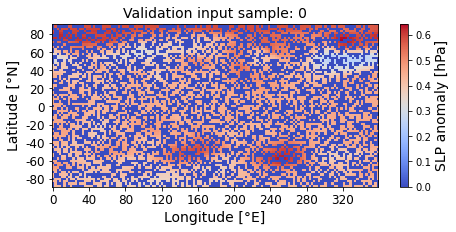

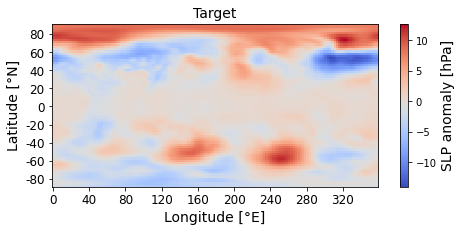

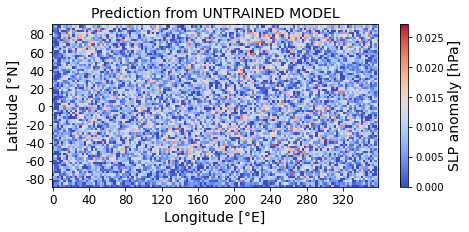

In [82]:
## Plot first input sample from VALIDATION data:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(val_input[i], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Validation input sample: '+str(i), fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot corresponding target:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(val_target[i], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Target', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot corresponding model prediction:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(val_pred[i,:,:,0], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Prediction from UNTRAINED MODEL', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()